In [1]:
# !pip install matplotlib
# !pip install pandas
#!pip install seaborn
# !pip install dask

import matplotlib
import numpy as np
import pandas as pd
import random
import sklearn
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
%matplotlib inline



from pathlib import Path
import dask.dataframe as dd
from dask.array import from_array
import numerapi
import seaborn as sns

from pyarrow.parquet import ParquetFile
import pyarrow as pa 

from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

In [2]:
napi = numerapi.NumerAPI()

In [3]:
napi.list_datasets()

['v2/numerai_datasets.zip',
 'v2/numerai_live_data.csv',
 'v2/numerai_live_data.csv.xz',
 'v2/numerai_live_data.parquet',
 'v3/example_predictions.csv',
 'v3/example_predictions.parquet',
 'v3/example_validation_predictions.csv',
 'v3/example_validation_predictions.parquet',
 'v3/features.json',
 'v3/numerai_datasets.zip',
 'v3/numerai_live_data.csv',
 'v3/numerai_live_data.parquet',
 'v3/numerai_live_data_int8.csv',
 'v3/numerai_live_data_int8.parquet',
 'v3/numerai_tournament_data.csv',
 'v3/numerai_tournament_data.parquet',
 'v3/numerai_tournament_data_int8.csv',
 'v3/numerai_tournament_data_int8.parquet',
 'v3/numerai_training_data.csv',
 'v3/numerai_training_data.parquet',
 'v3/numerai_training_data_int8.csv',
 'v3/numerai_training_data_int8.parquet',
 'v3/numerai_validation_data.csv',
 'v3/numerai_validation_data.parquet',
 'v3/numerai_validation_data_int8.csv',
 'v3/numerai_validation_data_int8.parquet',
 'v4/features.json',
 'v4/live.parquet',
 'v4/live_example_preds.parquet',


In [5]:
#Download single file
# train_pq_path = "numerai_training_data_int8.parquet"
# val_pq_path = "numerai_validation_data_int8.parquet"
tour_pq_path = "numerai_tournament_data_int8.parquet"
live_pq_path = "v3/numerai_live_data_int8.parquet"

# napi.download_dataset("numerai_training_data_int8.parquet", train_pq_path)
# napi.download_dataset("numerai_validation_data_int8.parquet", val_pq_path)
napi.download_dataset("numerai_tournament_data_int8.parquet", tour_pq_path)
napi.download_dataset("numerai_live_data_int8.parquet", "numerai_live_data_int8.parquet")

2022-05-28 22:34:56,646 INFO numerapi.utils: starting download
numerai_tournament_data_int8.parquet: 582MB [01:08, 8.46MB/s]                                                           
2022-05-28 22:36:06,911 INFO numerapi.utils: starting download
numerai_live_data_int8.parquet: 3.10MB [00:01, 2.28MB/s]                                                                


In [60]:
# #set datatype dictionary before import to reduce memory requirements
# data_type = {'target_bernie':np.int8, 'target_charles':np.int8,'target_elizabeth':np.int8,'target_jordan':np.int8, 'target_ken':np.int8}
# for j in range(1,51):
#     data_type['feature' + str(j)] = np.float16

# #import data 
# train_data = pd.read_parquet('numerai_training_data_int8.parquet')
# tournament_data = pd.read_parquet('numerai_validation_data_int8.parquet')

# Variabelen minder memory

In [4]:
#df_train row size

pf = ParquetFile('numerai_training_data_int8.parquet')
first_thousand_rows = next(pf.iter_batches(batch_size = 50000))
df_train = pa.Table.from_batches([first_thousand_rows]).to_pandas()

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, n003bba8a98662e4 to nb1c8ca60047b4ac
Columns: 1073 entries, era to target_thomas_60
dtypes: float32(21), int8(1050), object(2)
memory usage: 55.2+ MB


In [7]:
#df_train row size

pf2 = ParquetFile('numerai_validation_data_int8.parquet')
first_thousand_rows2 = next(pf2.iter_batches(batch_size = 50000))
df_val = pa.Table.from_batches([first_thousand_rows2]).to_pandas()

In [16]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, n003bba8a98662e4 to nb1c8ca60047b4ac
Columns: 1073 entries, era to target_thomas_60
dtypes: float32(21), int8(1050), object(2)
memory usage: 55.2+ MB


In [11]:
#df_tour row size

pf3 = ParquetFile('numerai_tournament_data_int8.parquet')
first_thousand_rows3 = next(pf3.iter_batches(batch_size = 500000))
df_tour = pa.Table.from_batches([first_thousand_rows3]).to_pandas()

In [12]:
df_tour.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, n000101811a8a843 to n8634f8c38b28c66
Columns: 1073 entries, era to target_thomas_60
dtypes: float64(21), int8(1050), object(2)
memory usage: 592.2+ MB


In [10]:
#read parquet files into dataframes


df_train_full = pd.read_parquet('numerai_training_data_int8.parquet')
# # df_val_full = pd.read_parquet('numerai_validation_data_int8.parquet')
df_tour_full = pd.read_parquet('numerai_tournament_data_int8.parquet')
df_live_full = pd.read_parquet('numerai_live_data_int8.parquet')



In [8]:
df_live_full

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,
n000100235947a2d,X,live,4,3,3,3,1,4,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n0011d3ad92431a7,X,live,3,3,2,2,4,0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n00185ad231387d7,X,live,4,3,3,4,3,2,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n002183a2cc5a66d,X,live,4,2,2,0,3,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n0039b890d0c312b,X,live,3,4,1,1,1,4,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc96a06048e7bc,X,live,3,4,2,3,2,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffdc7aba7f232dc,X,live,1,2,4,0,0,1,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffde29021034be9,X,live,3,2,1,3,2,2,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_val_full['data_type'].unique()

array(['validation'], dtype=object)

In [4]:
df_train_full.head()

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,4,2,4,4,0,0,4,4,...,0.25,0.25,0.25,0.00,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000
n003bee128c2fcfc,0001,train,2,4,1,3,0,3,2,3,...,1.00,1.00,1.00,1.00,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,2,1,3,0,3,0,3,3,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333
n00691bec80d3e02,0001,train,4,2,2,3,0,4,1,4,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,4,3,4,4,0,0,4,2,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000


In [6]:
df_train_full.data_type.unique()

array(['train'], dtype=object)

In [7]:
df_tour_full.data_type.unique()

array(['test', 'live'], dtype=object)

In [8]:
test_data = pd.DataFrame(df_tour_full[df_tour_full.data_type == 'test'])

In [9]:
test_data.head()

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,test,2,0,4,0,3,0,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n001e1318d5072ac,0575,test,1,4,2,2,1,3,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n002a9c5ab785cbb,0575,test,1,2,2,3,1,1,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n002ccf6d0e8c5ad,0575,test,2,4,2,4,2,4,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n0051ab821295c29,0575,test,2,0,0,1,0,4,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_train_full.info()
# print("#######################################")
# df_val_full.info()
# print("#######################################")
# df_tour_full.info()
# print("#######################################")

In [67]:
# df_train.head()

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,4,2,4,4,0,0,4,4,...,0.25,0.25,0.25,0.00,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000
n003bee128c2fcfc,0001,train,2,4,1,3,0,3,2,3,...,1.00,1.00,1.00,1.00,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,2,1,3,0,3,0,3,3,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333
n00691bec80d3e02,0001,train,4,2,2,3,0,4,1,4,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,4,3,4,4,0,0,4,2,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000


In [4]:
# features = [c for c in df_train_full if c.startswith("feature")]
# targets = [c for c in df_train_full if c.startswith("target")]

# df_train_full["erano"] = df_train_full.era.astype(int)
# eras = df_train_full.erano
# target = "target"

# features_erano = features + ["erano"]

In [5]:
# df_train_full["erano"] = df_train_full.era.astype(int)

In [11]:
features = [c for c in df_train_full if c.startswith("feature")]
print(features[:5]) # Print first 5 features
print("Number of features:", len(features))

['feature_dichasial_hammier_spawner', 'feature_rheumy_epistemic_prancer', 'feature_pert_performative_hormuz', 'feature_hillier_unpitied_theobromine', 'feature_perigean_bewitching_thruster']
Number of features: 1050


In [12]:
target = "target" # Main target you want to predict for the tournament
targets = [c for c in df_train_full if c.startswith("target")]
print(targets[:7]) # Print first 7 targets
print("Number of targets:", len(targets))

['target', 'target_nomi_20', 'target_nomi_60', 'target_jerome_20', 'target_jerome_60', 'target_janet_20', 'target_janet_60']
Number of targets: 21


In [13]:
print("Number of training eras:", len(set(df_train_full['era'])))

Number of training eras: 574


In [14]:
# Useful to convert 'era' column into ints 
df_train_full["erano"] = df_train_full.era.astype(int)
eras = df_train_full.erano

# Make sure our data doesn't use overlapped data
nonoverlap_eras = np.arange(1, 575, 4) # subsample every 4th era
df_train_full = df_train_full[df_train_full['erano'].isin(nonoverlap_eras)]

# # Useful to convert 'era' column into ints 
# df_val_full["erano"] = df_val_full.era.astype(int)
# eras = df_val_full.erano

# # Make sure our data doesn't use overlapped data
# nonoverlap_eras = np.arange(1, 575, 4) # subsample every 4th era
# df_val_full = df_val_full[df_val_full['erano'].isin(nonoverlap_eras)]



In [83]:
# splitting my arrays in ratio of 30:70 percent
X_train, X_test, y_train, y_test = train_test_split(df_train_full[features], df_train_full['target'], test_size=0.3, random_state=0)



In [10]:
df1 = df_train_full[eras<=eras.median()]
df2 = df_train_full[eras>eras.median()]

/tmp/ipykernel_109848/3237141178.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_train_full[eras<=eras.median()]
/tmp/ipykernel_109848/3237141178.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df_train_full[eras>eras.median()]


In [14]:
df1.to_csv('kd_mediaan.csv')
df2.to_csv('gd_mediaan.csv')

In [22]:
import lightgbm

if 'lgb_full_data.txt' is True: # Check if model is saved in current directory
  print("Loading LightGBM model...")
  lgb = lightgbm.Booster(model_file='lgb_full_data.txt')

else:
  print("Training LightGBM model...")
  # Hyperparameters are given from Numerai example script
  params = {
            "n_estimators": 1000,
            "learning_rate": 0.01,
            "max_depth": 5,
            "num_leaves": 2 ** 5,
            "colsample_bytree": 0.1}

  lgb = lightgbm.LGBMRegressor(**params) # Instantiate model
#   Train model op volledige data
#   lgb.fit(df_train_full[features], df_train_full[target]) # Train model
    
  #Train model op eerste helft eras
#   lgb.fit(df1[features], df1[target])

  # Train model op tweede heflt eras
  lgb.fit(df2[features], df2[target])  


    # Train Test Split
#   lgb.fit(X_train, y_train)
    
  lgb.booster_.save_model('lgb_DF2.txt') # Save model

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_22326/3008329718.py:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 'lgb_full_data.txt' is True: # Check if model is saved in current directory


Training LightGBM model...


### Optioneel Ensemble voor perfonmance boost

In [ ]:
# import lightgbm as lgb
# from sklearn import metrics
# from sklearn import preprocessing

# def auc2(m, train, test): 
#     return (metrics.roc_auc_score(y_train,m.predict(train)),
#                             metrics.roc_auc_score(y_test,m.predict(test)))

# lg = lgb.LGBMClassifier(silent=False, n_jobs = -1)
# param_dist = {"max_depth": [25,50, 75],
#               "learning_rate" : [0.01,0.05,0.1],
#               "num_leaves": [300,900,1200],
#               "n_estimators": [200]
#              }

# lab_enc = preprocessing.LabelEncoder()
# training_scores_encoded = lab_enc.fit_transform(y_train)


# grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
# grid_search.fit(train, training_scores_encoded)
# grid_search.best_estimator_

# d_train = lgb.Dataset(train, label=y_train)
# params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

# # Without Categorical Features
# model2 = lgb.train(params, d_train)
# auc2(model2, train, test)

# #With Catgeorical Features
# cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",
#                  "ORIGIN_AIRPORT"]
# model2 = lgb.train(params, d_train, categorical_feature = cate_features_name)
# auc2(model2, train, test)


# lab_enc = preprocessing.LabelEncoder()
# training_scores_encoded = lab_enc.fit_transform(labels_train)
# print(training_scores_encoded)
# print(utils.multiclass.type_of_target(labels_train))
# print(utils.multiclass.type_of_target(labels_train.astype('int')))
# print(utils.multiclass.type_of_target(training_scores_encoded))

# model = RFC()
# grid = GS(estimator=model, param_grid=parameters)
# grid.fit(features_train, training_scores_encoded)

In [10]:
import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt
model = lightgbm.Booster(model_file='lgb_full_data.txt') # Load model if already trained and saved


pd.DataFrame(model.feature_importance(), index=features, columns=['importance']).sort_values(by='importance', ascending=False).style.background_gradient(cmap='viridis')


,importance
feature_unvaried_social_bangkok,160
feature_haziest_lifelike_horseback,143
feature_lofty_acceptable_challenge,123
feature_silver_handworked_scauper,121
feature_exorbitant_myeloid_crinkle,121
feature_canalicular_peeling_lilienthal,119
feature_unaired_operose_lactoprotein,113
feature_moralistic_heartier_typhoid,111
feature_undivorced_unsatisfying_praetorium,108
feature_unflagging_goodlier_invalidism,105


In [30]:
importances = pd.DataFrame(model.feature_importance(), index=features, columns=['importance']).sort_values(by='importance', ascending=False)
importances

,importance
feature_unvaried_social_bangkok,160
feature_haziest_lifelike_horseback,143
feature_lofty_acceptable_challenge,123
feature_silver_handworked_scauper,121
feature_exorbitant_myeloid_crinkle,121
...,...
feature_unsatisfied_mesopotamian_woodruff,6
feature_nonfunctional_cnemial_illocution,6
feature_phenomenal_photosynthetic_berg,6
feature_talcose_patelliform_cana,4


In [31]:
features_top_100 = importances.head(100)
features_top_100

,importance
feature_unvaried_social_bangkok,160
feature_haziest_lifelike_horseback,143
feature_lofty_acceptable_challenge,123
feature_silver_handworked_scauper,121
feature_exorbitant_myeloid_crinkle,121
...,...
feature_midnightly_falser_replacement,53
feature_arborescent_fungal_despiser,53
feature_intended_involute_highbinder,53
feature_aloetic_presented_scarer,53


In [42]:
features_top_100

,importance
feature,
feature_unvaried_social_bangkok,160
feature_haziest_lifelike_horseback,143
feature_lofty_acceptable_challenge,123
feature_silver_handworked_scauper,121
feature_exorbitant_myeloid_crinkle,121
...,...
feature_midnightly_falser_replacement,53
feature_arborescent_fungal_despiser,53
feature_intended_involute_highbinder,53


In [47]:
# features_top_100.index.name = 'feature'
# features_top_100.reset_index()
# features_top_100
# features_100 = features_top_100['feature'].tolist()
# top_features = [f'{i}' for i in range(features_top_100.shape[1])]

top_features = features_top_100.index.tolist()
top_features

['feature_unvaried_social_bangkok',
 'feature_haziest_lifelike_horseback',
 'feature_lofty_acceptable_challenge',
 'feature_silver_handworked_scauper',
 'feature_exorbitant_myeloid_crinkle',
 'feature_canalicular_peeling_lilienthal',
 'feature_unaired_operose_lactoprotein',
 'feature_moralistic_heartier_typhoid',
 'feature_undivorced_unsatisfying_praetorium',
 'feature_unflagging_goodlier_invalidism',
 'feature_travelled_semipermeable_perruquier',
 'feature_gay_deceased_reen',
 'feature_pronominal_rampant_megaspore',
 'feature_flintier_enslaved_borsch',
 'feature_fragrant_fifteen_brian',
 'feature_precooled_inoperable_credence',
 'feature_antichristian_slangiest_idyllist',
 'feature_jerkwater_eustatic_electrocardiograph',
 'feature_coactive_prefatorial_lucy',
 'feature_jiggish_tritheist_probity',
 'feature_direst_interrupted_paloma',
 'feature_liege_unexercised_ennoblement',
 'feature_glare_factional_assessment',
 'feature_puberulent_nondescript_laparoscope',
 'feature_unforbidden_high

In [10]:
# import lightgbm
# import seaborn as sns
# import matplotlib.pyplot as plt
lgb = lightgbm.Booster(model_file='lgb_full_data.txt') # Load model if already trained and saved

# model = xgb.load_model('xgb_full_data.txt') # Load model if already trained and saved

# # make predictions
# yhat = lgb.predict(X_test)
# # yhat = model.predict(X_test)
# # evaluate predictions
# mae = mean_absolute_error(y_test, yhat)
# mse = mean_squared_error(y_test, yhat)
# print('MAE: %.3f' % mae)
# print('MAE: %.3f' % mse)

In [10]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

def score(df, prediction):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df['target'],
        df[prediction].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print()
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print(f"Max Drawdown: {np.min(era_scores):.4f}")
    print()
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

count    604111.000
mean          0.500
std           0.012
min           0.383
25%           0.493
50%           0.500
75%           0.508
max           0.574
Name: prediction, dtype: float64



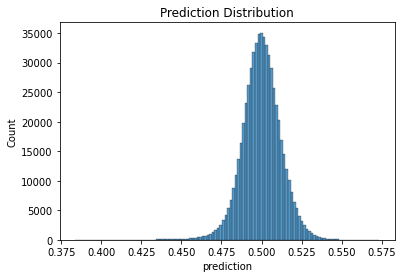


Training Correlation Score: 0.15538673614730136

Mean Correlation: 0.1480
Median Correlation: 0.1487
Standard Deviation: 0.0291

Mean Pseudo-Sharpe: 5.0787
Median Pseudo-Sharpe: 5.1024
Max Drawdown: 0.0549

Hit Rate (% positive eras): 100.00%


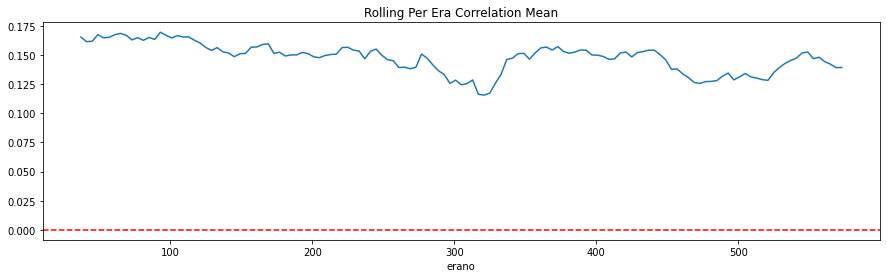

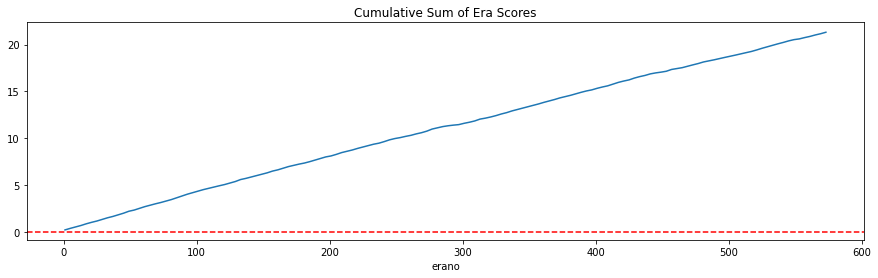

In [13]:
# Evaluate Training Data
df_train_full['prediction'] = lgb.predict(df_train_full[features])

# Check distribution of predictions
print(df_train_full['prediction'].describe().round(3))
print()
plt.title("Prediction Distribution")
sns.histplot(df_train_full['prediction'], bins=120)
plt.show()
print()

print("Training Correlation Score:", correlation_score(df_train_full['target'], df_train_full['prediction']))
print()
mean_train_era_scores = df_train_full.groupby(df_train_full['erano']).apply(score, prediction='prediction')
run_analytics(mean_train_era_scores)



# Evaluate Training Data
# df1['prediction'] = lgb.predict(df1[features])

# # Check distribution of predictions
# print(df1['prediction'].describe().round(3))
# print()
# plt.title("Prediction Distribution")
# sns.histplot(df1['prediction'], bins=120)
# plt.show()
# print()

# print("Training Correlation Score:", correlation_score(df1['target'], df1['prediction']))
# print()
# mean_train_era_scores = df1.groupby(df1['erano']).apply(score, prediction='prediction')
# run_analytics(mean_train_era_scores)


# Evaluate Training Data
# df2['prediction'] = lgb.predict(df2[features])

# # Check distribution of predictions
# print(df2['prediction'].describe().round(3))
# print()
# plt.title("Prediction Distribution")
# sns.histplot(df2['prediction'], bins=120)
# plt.show()
# print()

# print("Training Correlation Score:", correlation_score(df2['target'], df2['prediction']))
# print()
# mean_train_era_scores = df2.groupby(df2['erano']).apply(score, prediction='prediction')
# run_analytics(mean_train_era_scores)

count    539658.000
mean          0.500
std           0.012
min           0.424
25%           0.493
50%           0.500
75%           0.508
max           0.559
Name: prediction, dtype: float64



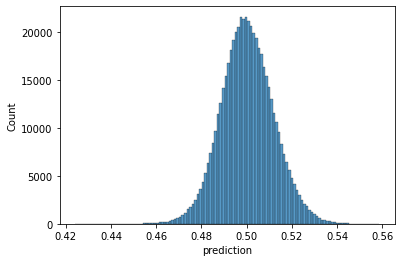

In [13]:
# Evaluate Validation Data
df_val_full['prediction'] = lgb.predict(df_val_full[features])

# Check distribution of predictions
print(df_val_full['prediction'].describe().round(3))
print()
sns.histplot(df_val_full['prediction'], bins=120)
plt.show()
print()

# print("Validation Correlation Score:", correlation_score(df_val_full['target'], df_val_full['prediction']))
# print()
# mean_valid_era_scores = df_val_full.groupby(df_val_full['erano']).apply(score, prediction='prediction')
# run_analytics(mean_valid_era_scores)

# Format prediction CSV for submission
prediction_df = df_val_full.reset_index()[['id', 'prediction']]
prediction_df[['id', 'prediction']].to_csv(f'round{current_round}_LGBM_FULL_VALIDATION_predictions.csv', index=False) # Important to name your CSV file so you know wh

In [12]:
# Download and Load Tournament data
#napi.download_dataset('numerai_tournament_data_int8.parquet', 'numerai_tournament_data_int8.parquet')
#tourney_df = pd.read_parquet('numerai_tournament_data_int8.parquet')
tourney_ids = df_tour_full.index
print()
print("Tournament Data Shape: ", df_tour_full.shape)
df_tour_full.head()


Tournament Data Shape:  (1412917, 1073)


,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,test,2,0,4,0,3,0,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n001e1318d5072ac,0575,test,1,4,2,2,1,3,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n002a9c5ab785cbb,0575,test,1,2,2,3,1,1,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n002ccf6d0e8c5ad,0575,test,2,4,2,4,2,4,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n0051ab821295c29,0575,test,2,0,0,1,0,4,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
import lightgbm

# lgb = lightgbm.Booster(model_file='lgb_full_data.txt') # Load model if already trained and saved
# lgb = lightgbm.Booster(model_file='lgb_df1.txt') # Load model if already trained and saved
lgb = lightgbm.Booster(model_file='lgb_df2.txt') # Load model if already trained and saved

# Generate tournament predictions (THIS MIGHT EXCEED VRAM THRESHOLD AND CRASH NOTEBOOK)
df_live_full['prediction'] = lgb.predict(df_live_full[features]) 

# Alternatively, we can split the tournament dataset to save VRAM and concatenate at the end
# tourney_preds_1 = lgb.predict(df_tour_full[features][:50000])
# tourney_preds_2 = lgb.predict(df_tour_full[features][50000:100000])
# tourney_preds_3 = lgb.predict(df_tour_full[features][100000:])
# df_tour_full['prediction'] = np.concatenate((tourney_preds_1, tourney_preds_2, tourney_preds_3))

count    1412910.000
mean           0.500
std            0.012
min            0.336
25%            0.493
50%            0.500
75%            0.508
max            0.561
Name: prediction, dtype: float64



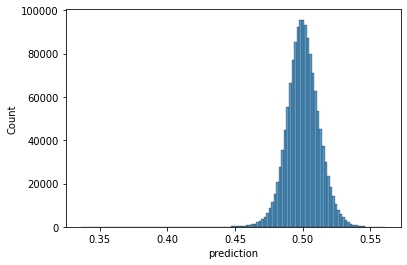

In [25]:
# Check distribution of predictions
print(df_tour_full['prediction'].describe().round(3))
print()
sns.histplot(df_tour_full['prediction'], bins=120)
plt.show()

In [16]:
# Instantiate Numerai API again but with API keys for submission
PUBLIC_KEY = '5NSQT45JK2Z3OKKESRSLOFXJ6ZCVCQJ4'
PRIVATE_KEY = 'EHXKWOAG55IA5CI6YJL5KVUAUKQUVDMHMZGWTM576APSCGB6SBAVN4H4VZ5QQG43'

napi = numerapi.NumerAPI(PUBLIC_KEY, PRIVATE_KEY)
current_round = napi.get_current_round()
print("ROUND NUMBER: ", current_round)

ROUND NUMBER:  318


In [24]:
# Format prediction CSV for submission
prediction_df = df_live_full.reset_index()[['id', 'prediction']]
prediction_df[['id', 'prediction']].to_csv(f'round{current_round}_LGBM_DF2_predictions.csv', index=False) # Important to name your CSV file so you know wh

In [25]:
# Submit CSV to Numerai 
# IMPORTANT TO SPECIFY version=2 TO SUBMIT TOURNAMENT PREDICTIONS FOR THE NEW DATASET
# USE version=1 IF SUBMITTING TOURNAMENT PREDICTIONS USING THE OLD DATASET


# MAT_BRAIN_BASE
# model_id = 'cabee025-4973-4de9-bf18-3c56f6c9f47e'

# MAT_BRAIN_DF1
# model_id = 'b5f4a62b-300b-4646-b6a1-6596105de061'

# # MAT_BRAIN_DF2
model_id = '12fbf66c-59a0-464c-b95c-d4a5cc457d2d'


napi.upload_predictions(f'round{current_round}_LGBM_DF2_predictions.csv', model_id=model_id, version=2)

2022-05-28 22:43:15,765 INFO numerapi.base_api: uploading predictions...


'696805a9-4131-4458-b038-0c5e4228d2b9'